# Conditional sampling of $v$ in time

Here, we try to carefully implement Section 8.7.1 of the notes. Once this seems to be working, we'll move it off to a module.

In [1]:
import numpy as np
np.random.seed(12345)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': '\\usepackage{amsmath}\\usepackage{amssymb}'
})

We'll start by definining some parameters:

In [2]:
N = 1000  # total number of samples
dt = 0.001  # sample spacing (in s)
taxis = np.arange(0, N * dt, dt)
freqs = np.fft.fftfreq(N, dt)
Omega = len(freqs)

Now we want to write a function that calculates $\boldsymbol{\phi}_t$ from the notes:

In [3]:
def phi(t, freqs):
    """
    Calculate phi_t as in notes. 
    Assumes \omega = 0 is at index 0!
    """
    phase = np.exp(1j * 2 * np.pi * freqs * t)
    phase[0] -= 1
    phase /= np.sqrt(freqs.shape[0])
    return phase

A simple test: We should have $\mathrm{iFFT}(x)(t) = \frac{\sqrt{\Omega - 1}}{\Omega}\boldsymbol{\phi}_t \cdot \mathbf{x}_t$ when $\mathbf{x}$ has no zero-frequency content.

In [4]:
x = np.random.randn(Omega)
x[0] = 0
ifftx = np.fft.ifft(x)

phix = (np.sqrt(Omega - 1)/Omega) * np.array([np.dot(phi(t, freqs), x) for t in taxis])

In [5]:
ifftx[:10], phix[:10]

(array([-2.14600335e-03+0.j        , -6.50349976e-03-0.01674351j,
        -7.94546976e-04-0.01437778j, -2.18389817e-03+0.02163435j,
        -1.83443498e-02+0.01355055j,  1.12652017e-02-0.03290786j,
         1.36228154e-02+0.00830542j, -4.59633893e-03+0.00479271j,
        -8.47744687e-05+0.00949672j,  1.23872095e-02-0.00857174j]),
 array([-2.14493008e-03+0.j        , -6.50024720e-03-0.01673514j,
        -7.94149604e-04-0.01437059j, -2.18280595e-03+0.02162353j,
        -1.83351753e-02+0.01354377j,  1.12595677e-02-0.0328914j ,
         1.36160023e-02+0.00830127j, -4.59404018e-03+0.00479031j,
        -8.47320709e-05+0.00949197j,  1.23810144e-02-0.00856746j]))

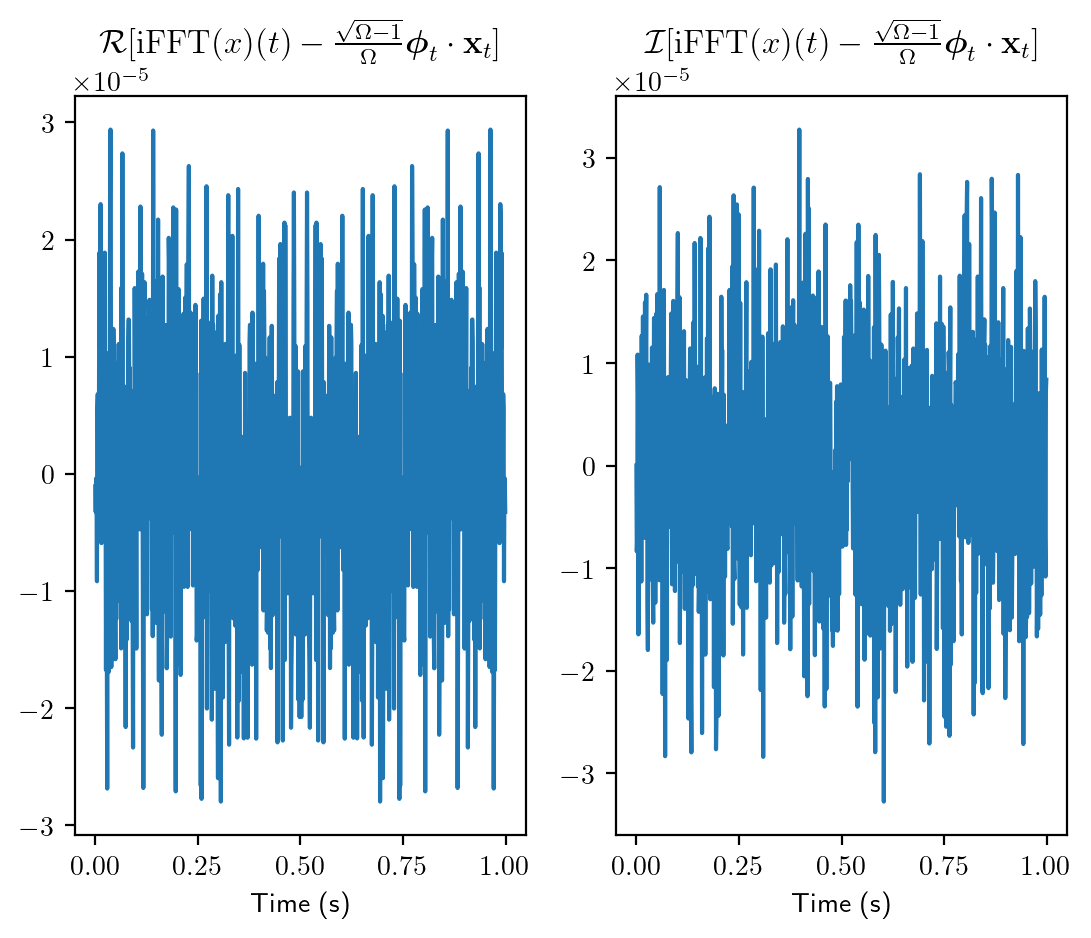

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(taxis, np.real(ifftx - phix))
ax[0].set_title(r"$\mathcal{R}[\mathrm{iFFT}(x)(t) - \frac{\sqrt{\Omega - 1}}{\Omega}\boldsymbol{\phi}_t \cdot \mathbf{x}_t]$")
ax[0].set_xlabel("Time (s)")
ax[1].plot(taxis, np.imag(ifftx - phix))
ax[1].set_title(r"$\mathcal{I}[\mathrm{iFFT}(x)(t) - \frac{\sqrt{\Omega - 1}}{\Omega}\boldsymbol{\phi}_t \cdot \mathbf{x}_t]$")
ax[1].set_xlabel("Time (s)");

## Programming the solution

From the notes, if we have $\mathbf{v}_{t-1}$, then the optimal choice for the next time point $\mathbf{\hat{v}}_t$ is given by
$$
\mathbf{\hat{v}}_t = \frac{\mathbf{v}_{t-1} + \lambda^* \boldsymbol{\phi}^*_t}{\sqrt{1 + |\lambda|^2 + 2\mathrm{Re}(\lambda (\mathbf{v}_{t-1} \cdot \boldsymbol{\phi}_t))}}
$$
with
$$
\lambda = -(\mathbf{v}^*_{t-1} \cdot \boldsymbol{\phi}^*_t) + \frac{\Omega}{\sqrt{\Omega - 1}}\frac{\hat{m}_t}{f_t}\sqrt{\frac{1 - |\mathbf{v}_{t-1} \cdot \boldsymbol{\phi}_t|^2}{1 - \frac{\Omega^2}{\Omega - 1} (\hat{m}_t/f_t)^2}}.
$$
We want a function that performs this calculation.

In [7]:
vprev = np.random.randn(Omega) + np.random.randn(Omega) * 1j
vprev /= np.linalg.norm(vprev)
bt = .7/np.sqrt(Omega)
t = 0.1

In [8]:
def vhat(vprev, bt, t, Omega, dt):
    """
    vprev = v_{t-1}
    bt    = \hat{m}_t/f_t
    t     = time
    Omega = number of frequencies
    """
    freqs = np.fft.fftfreq(Omega, dt)
    phit = phi(t, freqs)
    alpha = np.dot(vprev, phit)
    oo = Omega/np.sqrt(Omega - 1)
    lam = -np.conj(alpha) + oo * bt * np.sqrt((1 - np.abs(alpha)**2)/(1 - (oo * bt)**2))
    
    vv = (vprev + np.conj(lam * phit))/np.sqrt(1 + np.abs(lam)**2 + 2 * np.real(lam * alpha))
    
    return vv

Now some tests: is the output on the unit sphere?

In [9]:
vv = vhat(vprev, bt, t, Omega, dt)

print(f"The norm of vhat is {np.linalg.norm(vv)}.")

The norm of vhat is 0.9997704058003818.


And do we solve $\boldsymbol{\phi}_t \cdot \mathbf{v}_t = \frac{\Omega}{\sqrt{\Omega - 1}}\frac{\hat{m}_t}{f_t}$?

In [10]:
phit = phi(t, np.fft.fftfreq(Omega, dt))
phiv = np.dot(phit, vv)
oo = Omega/np.sqrt(Omega - 1)
print(f"phi . v = {phiv}")
print(f"oo * bt = {oo * bt}")

phi . v = (0.6996727023628546+6.902868910451873e-06j)
oo * bt = 0.7003502627189416


These are pretty close, but not super accurate.